## Own resize multilinear

A function that implements linear interpolation for N Dimensions.

In [7]:
import tensorflow as tf
import numpy as np
import sys, os
import matplotlib.pyplot as plt
%matplotlib inline
import time

wk_dir = os.path.abspath(os.path.dirname('__file__'))

In [8]:
def _get_string_binary(number, lenght):
    number_bin = format(number, "b")
    string_binary = '0'*lenght
    string_binary = string_binary[:lenght-len(number_bin)] + number_bin
    return string_binary

In [9]:
def _get_multilinear_value(channel, position):
    """
    Calculates the interpolated value for a given position in the channel content.
    args:
        channel: A N-D Tensor [D0, D1, ..., DN-1]
        position: A 1-D float32 Tensor of N elements. Contents the position in the channel. 
    """
    N = position.shape[0]
    # Dictionary with the values around the target position and the fraction
    # of the position
    surrounds = {}
    
    # for each dimension extract the coordinates near to the position 'T'
    for d in range(N):
        integer_part = int(position[d])
        fraction_part = position[d] - integer_part
        integer_part_plus_one = min(integer_part + 1, channel.shape[d] - 1)
        
        surrounds[d] = {'0': integer_part,
                        '1': integer_part_plus_one,
                        'T': fraction_part}

    value = 0
    # for each element in the multilinear calculation
    for i in range(2**N):
        temp = 1.0
        # position of the element in the format '0000101'
        position_to_read = _get_string_binary(i, N)
        
        coordinate = []
        # l_r left or right, ic can be '0' or '1'
        for d, l_r in enumerate(reversed(range(len(position_to_read)))):
            # coordinate in the channel of the value multiplying the element 
            coordinate.append(surrounds.get(d).get(position_to_read[l_r]))
            
            # multiplication in the element
            if position_to_read[l_r] == '0':
                temp = temp * (1.0 - surrounds.get(d).get('T'))
            else:
                temp = temp * surrounds.get(d).get('T')
        
        # the element times the value at the coordinate in the channel
        temp = temp * channel.item(tuple(coordinate))
        # summing all the elements
        value = value + temp

    return int(value + 0.5)

In [10]:
# test
a = np.ones((6, 4), dtype=np.float32)
a[:, 0] = 50.0
#a[4, :] = 5.0

position = np.ones((2), dtype=np.float32)
position[0] = 0.1
position[1] = 0.1


value = get_multilinear_value(a, position)
print('value:', value)

value: 45


In [11]:
def _resize_channel_multilinear(channel, size):
    """
    Resizes content in N dimensions to size using multiliniear interpolation.
    args:
        images: An (N + 2)-D Tensor [D0, D1, ..., DN-1]
        size: A 1-D int32 Tensor of N elements: new_0D, new_1D,..new_N-1D 
    """
    N = size.shape[0]
    # This is the only code limiting N, but can be extended easily
    assert N <= 4
    assert N >= 2
    
    # new image
    #resized_channel = tf.zeros(size, dtype=tf.int32)
    resized_channel = np.zeros(size, dtype = int)
    
    scale = []
    for d in range(N):
        scale.append(float(channel.shape[d]) / float(size[d]))
    # finds positions in the original image and interpolates
    for i in range(size[0]):
        for j in range(size[1]):
            if N > 2:
                for k in range(size[2]):
                    if N > 3:
                        # Case for N = 4
                        for l in range(size[3]):
                            pass
                    else:
                        # Case for N = 3
                        pass
            else:
                # Case for N = 2
                position = np.ones((2), dtype=np.float32)
                position[0] = i * scale[0]
                position[1] = j * scale[1]
                value = _get_multilinear_value(channel, position)
                resized_channel[i, j] = value
    return resized_channel

In [13]:
a = np.ones((4, 4), dtype=np.float32)
a[:, 1] = 50.0
#a[4, :] = 5.0

size = np.ones((2), dtype=np.int32)
size[0] = 8
size[1] = 8


value = _resize_channel_multilinear(a, size)
print('value:', value)

value: [[ 1 26 50 26  1  1  1  1]
 [ 1 26 50 26  1  1  1  1]
 [ 1 26 50 26  1  1  1  1]
 [ 1 26 50 26  1  1  1  1]
 [ 1 26 50 26  1  1  1  1]
 [ 1 26 50 26  1  1  1  1]
 [ 1 26 50 26  1  1  1  1]
 [ 1 26 50 26  1  1  1  1]]


In [14]:
def resize_multilinear(content, size):
    """
    Resizes content in N dimensions to size using multiliniear interpolation.
    args:
        images: An (N + 2)-D Tensor [batch, D0, D1, ..., DN-1, channels]
        size: A 1-D int32 Tensor of N elements: new_0D, new_1D,..new_N-1D 
    """
    batches = content.shape[0]
    channels = content.shape[-1]
    
    new_size = list(content.shape)
    new_size[1:len(new_size)-1] = size
    
    # new content
    # resized_channel = tf.zeros(size, dtype=tf.int32)   
    resized_content = np.zeros(new_size, dtype=int)
    
    for batch in range(batches):
        for channel in range(channels):
            img_channel = content[batch, ..., channel]
            resized_channel = _resize_channel_multilinear(img_channel, size)
            
            resized_content[batch,...,channel] = resized_channel

    return resized_content

In [15]:
# read an image and resize it
file_name = 'images/android.png'
file_path = os.path.join(wk_dir, file_name)

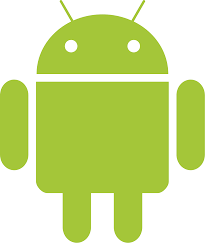

In [16]:
# Original
from IPython.display import Image
Image(file_name)

Execution time: 0.7430567741394043


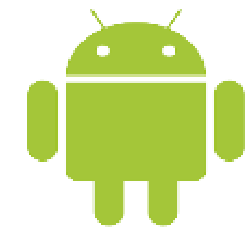

In [17]:
new_size = np.ones((2), dtype=np.int32)
new_size[0] = 100
new_size[1] = 100

# Using resize_multilinear

image_content = tf.read_file(file_path)
image_decoded = tf.image.decode_png(image_content, channels=0)
images = tf.expand_dims(image_decoded, 0)
images_resized = tf.py_func(resize_multilinear, [images, new_size], tf.int64)

start = time.time()
with tf.Session() as sess:
    my_result = sess.run(images_resized)
print('Execution time:', time.time() - start)
    
fig, ax = plt.subplots()
ax.imshow(my_result[0, :, :, :])
ax.axis('off')  # clear x-axis and y-axis
plt.show()

Execution time: 0.005507707595825195


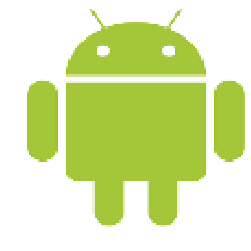

In [18]:
# Using tf.image.resize_bilinear

image_content = tf.read_file(file_path)
image_decoded = tf.image.decode_png(image_content, channels=0)
images = tf.expand_dims(image_decoded, 0)
images_resized = tf.image.resize_bilinear(images, new_size)
images_resized_int = tf.cast(images_resized, tf.int32)

start = time.time()
with tf.Session() as sess:
    tf_result = sess.run(images_resized_int)
print('Execution time:', time.time() - start)

fig, ax = plt.subplots()
ax.imshow(tf_result[0, :, :, :])
ax.axis('off')  # clear x-axis and y-axis
plt.show()

#### Differences

In [ ]:
diff = my_result[0, :, :, :] - tf_result[0, :, :, :]

In [ ]:
diff[:,:,:].max()

There is most probably an error in how floats get rounded to int